### Imports and Extracts

First of all, we import the necessary libraries

In [ ]:
import numpy as np
np.random.seed(0)
from keras.datasets import cifar10
from keras import backend as K
import pandas as pd
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import pickle

Then we start out by bringing in a couple of pretrained network models (credit to [Hyperparticle](https://github.com/Hyperparticle) for gathering the networks!)

In [ ]:
!sudo apt-get install subversion
!svn export https://github.com/Hyperparticle/one-pixel-attack-keras/trunk/networks
!unzip one-pixel-attack-models.zip -d networks/models/
!rm one-pixel-attack-models.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 

### Warming Up

In [ ]:
# Custom Networks
from networks.pure_cnn import PureCnn
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet

Now let's start out by loading the CIFAR-10 dataset!

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
class_names = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

Let's display a random image of the test set (just a sanity check!)

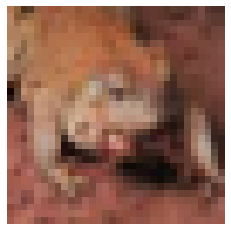

In [ ]:
plt.axis('off')
plt.imshow(x_test[5])

### Initial Experiments

Our next step will be to apply a perturbation on a target image

In [ ]:
def perturb_single_image(pixel, img):

    x_pos, y_pos, *rgb = pixel
    img = np.tile(img, 1) # copy the img to prevent change of original data!
    img[x_pos, y_pos] = rgb
    
    return img

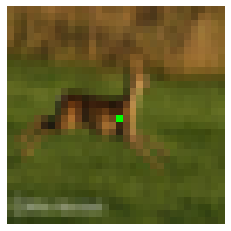

In [ ]:
image_id = 805 # idx in test set
pixel = np.array([16, 16, 0, 255, 0]) # pixel = x_pos, y_pos, red, green, blue
image_perturbed = perturb_single_image(pixel, x_test[image_id])

plt.axis('off')
plt.imshow(image_perturbed)

Now we bring in the models

In [ ]:
pure_cnn = PureCnn()
resnet = ResNet()
densenet = DenseNet()
wide_resnet = WideResNet()

models = [pure_cnn, resnet, densenet, wide_resnet]

Successfully loaded pure_cnn
Successfully loaded resnet
Successfully loaded densenet
Successfully loaded wide_resnet


Before demonstrating the attack on the pretrained networks, we first evaluate their current accuracy

In [ ]:
def evaluate_models(models, x_test, y_test):
    correct_imgs = []
    network_stats = []
    for model in models:
        print('Evaluating', model.name)

        predictions = model.predict(x_test)

        correct = [[model.name, i, label, np.max(pred), pred]
                   for i, (label, pred)
                   in enumerate(zip(y_test[:, 0], predictions))
                   if label == np.argmax(pred)]
        accuracy = len(correct) / len(x_test)

        correct_imgs += correct
        network_stats += [[model.name, accuracy, model.count_params()]]
    return network_stats, correct_imgs

In [ ]:
network_stats, correct_imgs = evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating pure_cnn
Evaluating resnet
Evaluating densenet
Evaluating wide_resnet


,name,accuracy,param_count
0,pure_cnn,0.8877,1369738
1,resnet,0.9231,470218
2,densenet,0.9467,850606
3,wide_resnet,0.9534,11318026


We have some pretty good models here! Now we begin the attack.

Since this attack is a black-box attack, the only information necessary is the input/output of the model (which are the images and their corresponding prediction probabilities, respectively)

In [ ]:
def predict_class(x, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    img_perturbed = perturb_single_image(x, img)
    predictions = model.predict(img_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

Let's test this new prediction on an example perturbed image

New Confidence in true class deer is [0.74156505]
Prior confidence was 0.7452274


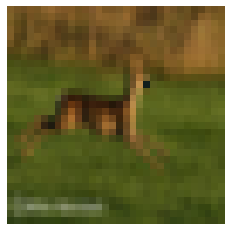

In [ ]:
image_id = 805
pixel = np.array([11, 20,  17, 30, 28])
model = pure_cnn

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
confidence = predict_class(pixel, x_test[image_id], true_class, model)

print('New Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)

img_perturbed = perturb_single_image(pixel, x_test[image_id])

plt.axis('off')
plt.imshow(img_perturbed)

Didn't change that much? Let's test it out on a couple of random pixels

In [ ]:
def pixel_generator(n):
  np.random.seed(0) # change the seed at your desire :D
  pixels = []
  for i in range(n):
    sample = np.random.rand(5)
    weights = [31, 31, 255, 255, 255] # CIFAR-10 image boundaries
    pixel = np.multiply(sample, weights)
    pixel = pixel.astype(int)
    pixels.append(pixel)
  return pixels

In [ ]:
def bombard_image(pixels, image_id, target_class, model, minimize=True):
  succ = [] # successful attacks

  true_class = y_test[image_id, 0]
  prior_confidence = model.predict_one(x_test[image_id])[true_class]
  print('Prior confidence was', prior_confidence)

  for pixel in pixels:
    confidence = predict_class(pixel, x_test[image_id], true_class, model)
    img_perturbed = perturb_single_image(pixel, x_test[image_id])
    if np.abs(confidence - prior_confidence) > 0.2:
      print('Confidence in true class', class_names[true_class], 'is', confidence)
      succ.append(img_perturbed)
  
  return succ

In [ ]:
image_id = 805
pixels = pixel_generator(20)
model = pure_cnn
true_class = y_test[image_id, 0]
succ = bombard_image(pixels, image_id, class_names[true_class], model)
print(len(succ))

Prior confidence was 0.7452274
Confidence in true class deer is [0.38166356]
Confidence in true class deer is [0.06929329]
Confidence in true class deer is [0.4308022]
3


Wow! We've already got 3 successfuly perturbed images with only 20 tries! (you can change seed if you want. It's been fixed there for reproducability reasons)

Let's plot these preturbed images

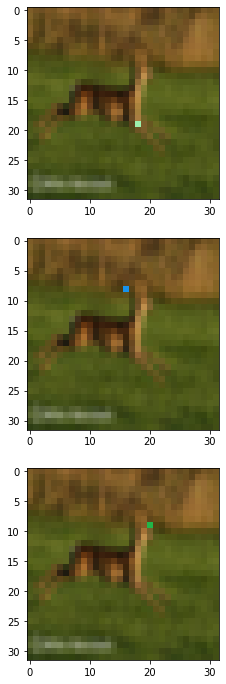

In [ ]:
fig = plt.figure(figsize=(12, 12))
columns = 1
rows = len(succ)
for i in range(0, columns*rows):
    img = succ[i]
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)
plt.show()

It's quite interesting that by simply randomly changing the color of a single pixel, you can reduce the confidence of the network as low as only 6%!

Now that we've got a flavor of the effectiveness of this attack, we can switch to a more structured (and profound) approach to generate our attack

First we define a function called `attack_success`. It will determine whether our preturbed image has been successfully misclassified or not.

In [ ]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False, multi=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    if not multi:
      attack_image = perturb_single_image(x, img)
    else:
      attack_image = perturb_multi_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('New Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        print('Image successfully misclassified to class: {} with confidence {} (targeted: {})'.format(class_names[predicted_class], confidence[predicted_class], targeted_attack))
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

Let's test it out

deer
New Confidence: 0.06929329
Image successfully misclassified to class: dog with confidence 0.5220072269439697 (targeted: False)
Prior confidence 0.7452274
Attack success: True


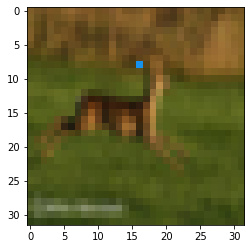

In [ ]:
image_id = 805
pixel = np.array([8, 16, 23, 146, 236])
model = pure_cnn

true_class = y_test[image_id, 0]
print(class_names[true_class])
prior_confidence = model.predict_one(x_test[image_id])[true_class]
success = attack_success(pixel, x_test[image_id], true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)

plt.imshow(perturb_single_image(pixel, x_test[image_id]))

Again, with just one pixel, the network is fooled to misclassify the image as a dog (with 52% confidence, which is quite remarkable)

### Differential Evolution (DE)

In order to organize our attacks more directly, we use Differential Evolution (DE). Differential Evolution is an evolutionary-based algorithm that tends to maximize the fitness function it has been assigned to. Let's see how it's done in action!

Since we're dealine with multiple perturbations instead of a single one, we need to change our previous `perturb_single_image` slightly.

In [ ]:
def perturb_multi_image(pixels, img):
    if pixels.ndim < 2:
        pixels = np.array([pixels])

    tile = [len(pixels)] + [1]*(pixels.ndim+1)
    imgs = np.tile(img, tile) # copy the img to prevent change of original data!

    pixels = pixels.astype(int)

    for pixel_batch, img in zip(pixels, imgs):
      pixels_info = np.split(pixel_batch, len(pixel_batch) // 5)
      for pixel_info in pixels_info:
          x_pos, y_pos, *rgb = pixel_info
          img[x_pos, y_pos] = rgb
    
    return imgs

Then we need to define our fitness function, which will be minimizing the current true class probability in case of an untargeted attack, and maximizing the target class in case of a targeted attack.

In [ ]:
def predict_classes(pixels, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_multi_image(pixels, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

In [ ]:
def plot_image(image, label_true=None, class_names=None, label_pred=None):
    if image.ndim == 4 and image.shape[0] == 1:
        image = image[0]

    plt.grid()
    plt.imshow(image.astype(np.uint8))

    # Show true and predicted classes
    if label_true is not None and class_names is not None:
        labels_true_name = class_names[label_true]
        if label_pred is None:
            xlabel = "True: " + labels_true_name
        else:
            # Name of the predicted class
            labels_pred_name = class_names[label_pred]

            xlabel = "True: " + labels_true_name + "\nPredicted: " + labels_pred_name

        # Show the class on the x-axis
        plt.xlabel(xlabel)

    plt.xticks([])  # Remove ticks from the plot
    plt.yticks([])
    plt.show()  # Show the plot

In [ ]:
def attack(img_id, model, target=None, 
           maxiter=30, popsize=100, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img_id, 0]
    
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)]
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class, 
                              model, targeted_attack, verbose, multi=True)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_multi_image(attack_result.x, x_test[img_id])[0]
    prior_probs = model.predict_one(x_test[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    # plt.imshow(attack_image)
    plot_image(attack_image, actual_class, class_names, predicted_class)
    print('image {} classified as {}'.format(class_names[actual_class], class_names[predicted_class]))

    return [model.name, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x, attack_image]

Here, we use the Scipy's differential evolution to initiate and evolve our perturbations.

Now let's test it out! First with an untargeted attack

New Confidence: 0.11395747
Image successfully misclassified to class: dog with confidence 0.6611811518669128 (targeted: False)
image deer classified as dog


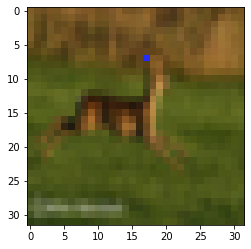

In [ ]:
image_id = 805
model = pure_cnn

_ = attack(image_id, model, verbose=True)

And then a targeted attack

Attacking with target dog
New Confidence: 0.4860147
Image successfully misclassified to class: dog with confidence 0.4860146939754486 (targeted: True)
image deer classified as dog


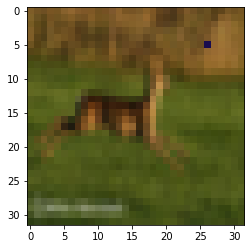

In [ ]:
image_id = 805
target_class = 5 # Integer in range 0-9
model = pure_cnn

print('Attacking with target', class_names[target_class])
_ = attack(image_id, model, target_class, verbose=True)

### Testing on all Models

Now we evaluate our attack on all our models!

In [ ]:
def attack_all(models, samples=150, targeted=False,
               maxiter=30, popsize=150, verbose=False):
    results = []
    for model in models:
        model_results = []
        valid_imgs = correct_imgs[correct_imgs.name == model.name].img
        img_samples = np.random.choice(valid_imgs, samples, replace=False)

        for i, img_id in enumerate(img_samples):
            print('\n', model.name, '- image', img_id, '-', i+1, '/', len(img_samples))
            targets = [None] if not targeted else range(5)
            
            for target in targets:
                if targeted:
                    print('Attacking with target', class_names[target])
                    if target == y_test[img_id, 0]:
                        continue
                result = attack(img_id, model, target, 
                                maxiter=maxiter, popsize=popsize, 
                                verbose=verbose)
                model_results.append(result)
                  
        results += model_results
      
        filename = 'targeted' if targeted else 'untargeted'
        with open('networks/results/' + filename + '_results.pkl', 'wb') as file:
            pickle.dump(results, file)

    return results


 pure_cnn - image 5736 - 1 / 50


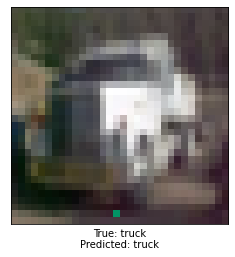

image truck classified as truck

 pure_cnn - image 8442 - 2 / 50


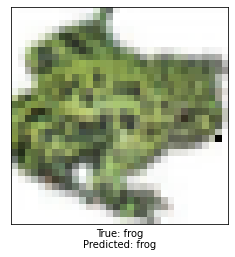

image frog classified as frog

 pure_cnn - image 5923 - 3 / 50


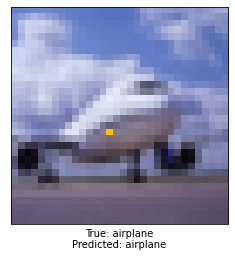

image airplane classified as airplane

 pure_cnn - image 9652 - 4 / 50
Image successfully misclassified to class: frog with confidence 0.8883771896362305 (targeted: False)


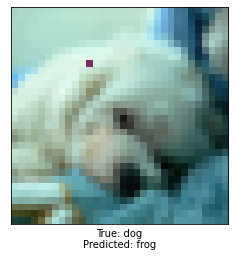

image dog classified as frog

 pure_cnn - image 7305 - 5 / 50


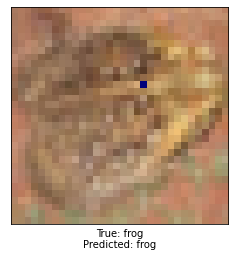

image frog classified as frog

 pure_cnn - image 8514 - 6 / 50
Image successfully misclassified to class: deer with confidence 0.8996644616127014 (targeted: False)


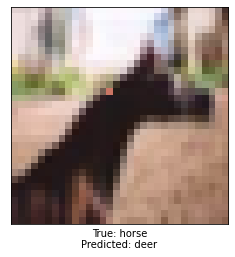

image horse classified as deer

 pure_cnn - image 420 - 7 / 50


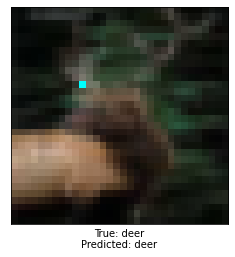

image deer classified as deer

 pure_cnn - image 8526 - 8 / 50
Image successfully misclassified to class: dog with confidence 0.6084442734718323 (targeted: False)


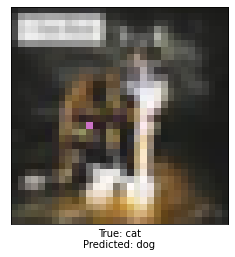

image cat classified as dog

 pure_cnn - image 4052 - 9 / 50


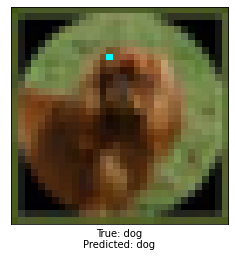

image dog classified as dog

 pure_cnn - image 1058 - 10 / 50


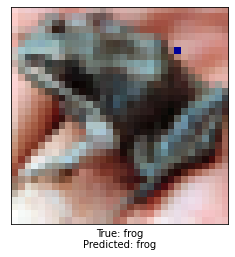

image frog classified as frog

 pure_cnn - image 1260 - 11 / 50


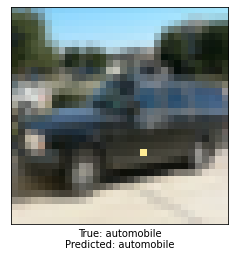

image automobile classified as automobile

 pure_cnn - image 2429 - 12 / 50


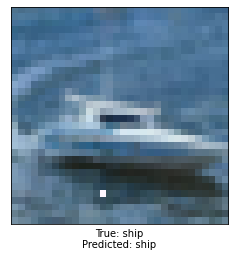

image ship classified as ship

 pure_cnn - image 281 - 13 / 50


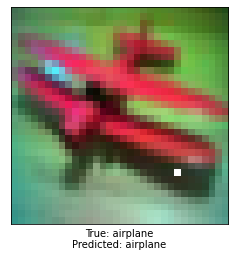

image airplane classified as airplane

 pure_cnn - image 2074 - 14 / 50


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:773: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


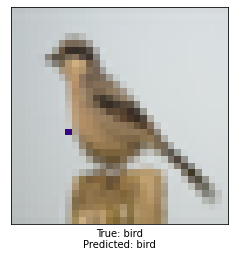

image bird classified as bird

 pure_cnn - image 8939 - 15 / 50


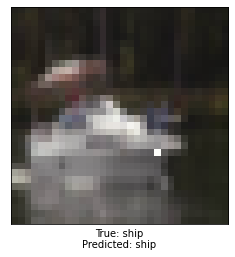

image ship classified as ship

 pure_cnn - image 7465 - 16 / 50


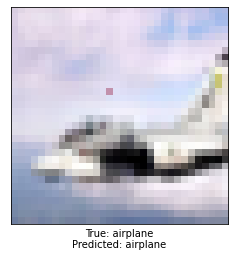

image airplane classified as airplane

 pure_cnn - image 1393 - 17 / 50
Image successfully misclassified to class: frog with confidence 0.5826608538627625 (targeted: False)


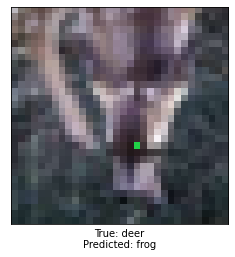

image deer classified as frog

 pure_cnn - image 6965 - 18 / 50


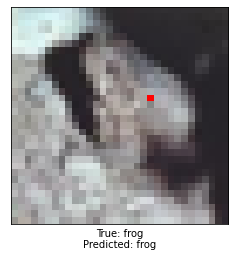

image frog classified as frog

 pure_cnn - image 8156 - 19 / 50


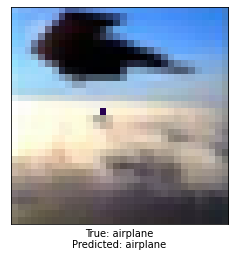

image airplane classified as airplane

 pure_cnn - image 219 - 20 / 50


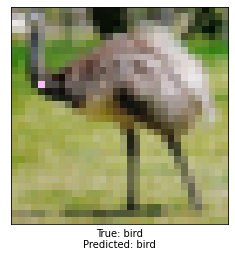

image bird classified as bird

 pure_cnn - image 54 - 21 / 50


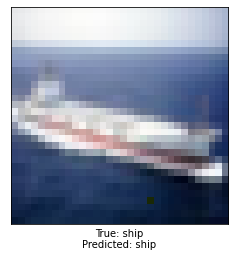

image ship classified as ship

 pure_cnn - image 3187 - 22 / 50


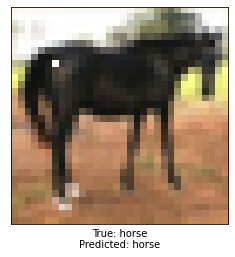

image horse classified as horse

 pure_cnn - image 8575 - 23 / 50


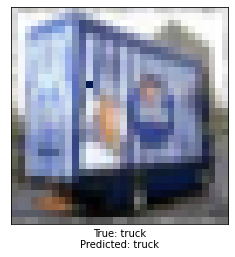

image truck classified as truck

 pure_cnn - image 1547 - 24 / 50
Image successfully misclassified to class: airplane with confidence 0.5034590363502502 (targeted: False)


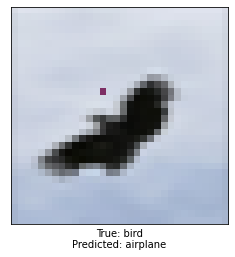

image bird classified as airplane

 pure_cnn - image 41 - 25 / 50


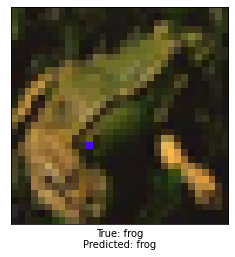

image frog classified as frog

 pure_cnn - image 3964 - 26 / 50


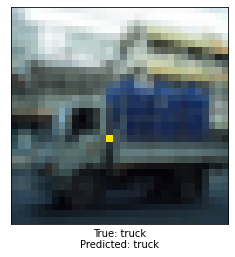

image truck classified as truck

 pure_cnn - image 384 - 27 / 50
Image successfully misclassified to class: dog with confidence 0.9257292151451111 (targeted: False)


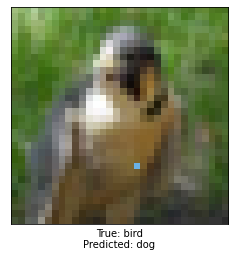

image bird classified as dog

 pure_cnn - image 7189 - 28 / 50


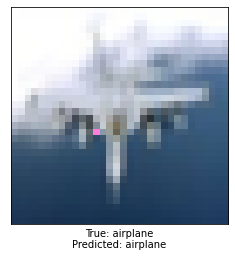

image airplane classified as airplane

 pure_cnn - image 1809 - 29 / 50


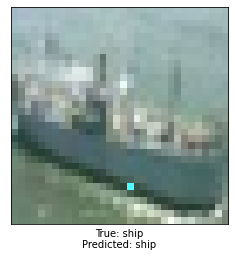

image ship classified as ship

 pure_cnn - image 6350 - 30 / 50


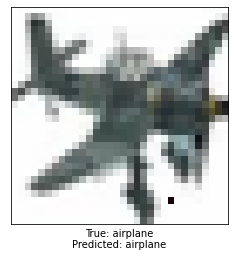

image airplane classified as airplane

 pure_cnn - image 2539 - 31 / 50


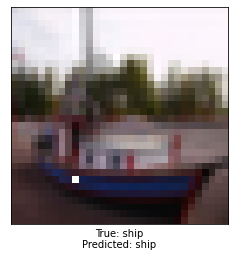

image ship classified as ship

 pure_cnn - image 1734 - 32 / 50


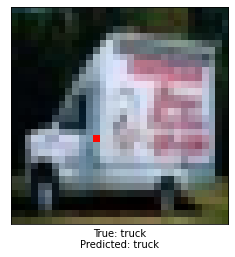

image truck classified as truck

 pure_cnn - image 4554 - 33 / 50
Image successfully misclassified to class: horse with confidence 0.6001302003860474 (targeted: False)


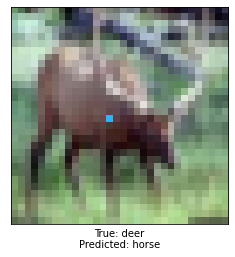

image deer classified as horse

 pure_cnn - image 4345 - 34 / 50


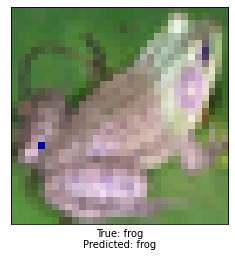

image frog classified as frog

 pure_cnn - image 9382 - 35 / 50


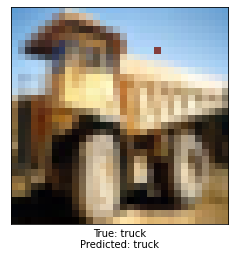

image truck classified as truck

 pure_cnn - image 4108 - 36 / 50


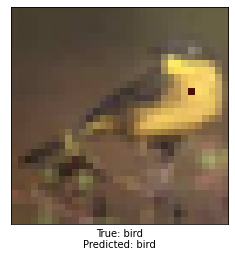

image bird classified as bird

 pure_cnn - image 274 - 37 / 50


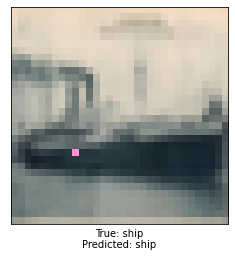

image ship classified as ship

 pure_cnn - image 6508 - 38 / 50


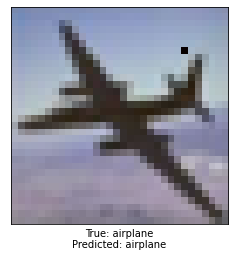

image airplane classified as airplane

 pure_cnn - image 7783 - 39 / 50
Image successfully misclassified to class: dog with confidence 0.6402210593223572 (targeted: False)


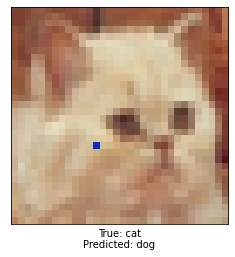

image cat classified as dog

 pure_cnn - image 7607 - 40 / 50


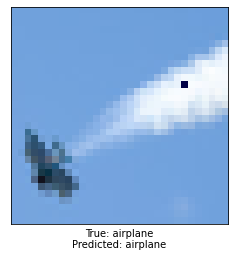

image airplane classified as airplane

 pure_cnn - image 5062 - 41 / 50


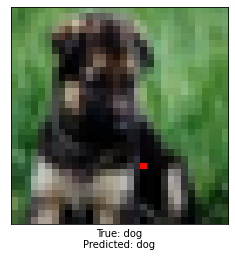

image dog classified as dog

 pure_cnn - image 8317 - 42 / 50
Image successfully misclassified to class: cat with confidence 0.6724346280097961 (targeted: False)


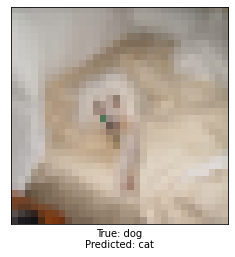

image dog classified as cat

 pure_cnn - image 7697 - 43 / 50
Image successfully misclassified to class: horse with confidence 0.7526567578315735 (targeted: False)


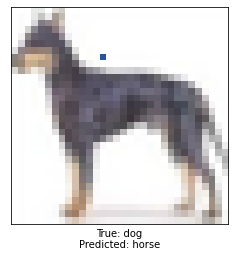

image dog classified as horse

 pure_cnn - image 9893 - 44 / 50


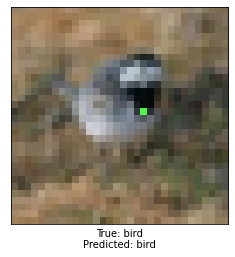

image bird classified as bird

 pure_cnn - image 5645 - 45 / 50
Image successfully misclassified to class: cat with confidence 0.7737171649932861 (targeted: False)


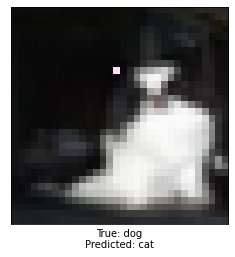

image dog classified as cat

 pure_cnn - image 2430 - 46 / 50


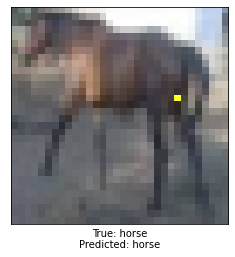

image horse classified as horse

 pure_cnn - image 597 - 47 / 50
Image successfully misclassified to class: bird with confidence 0.692304253578186 (targeted: False)


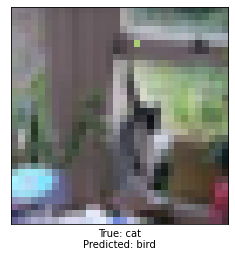

image cat classified as bird

 pure_cnn - image 961 - 48 / 50


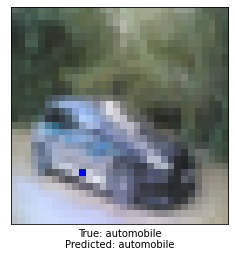

image automobile classified as automobile

 pure_cnn - image 2108 - 49 / 50
Image successfully misclassified to class: dog with confidence 0.7630204558372498 (targeted: False)


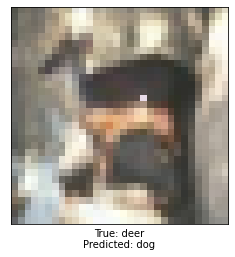

image deer classified as dog

 pure_cnn - image 7997 - 50 / 50


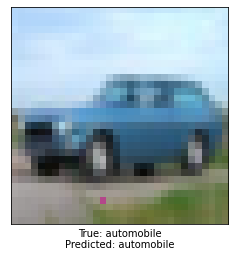

image automobile classified as automobile

 resnet - image 2914 - 1 / 50


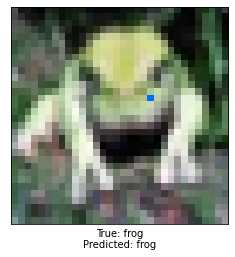

image frog classified as frog

 resnet - image 971 - 2 / 50
Image successfully misclassified to class: dog with confidence 0.500056803226471 (targeted: False)


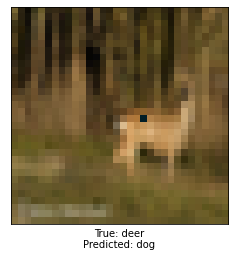

image deer classified as dog

 resnet - image 7841 - 3 / 50
Image successfully misclassified to class: dog with confidence 0.5524856448173523 (targeted: False)


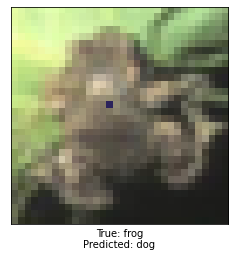

image frog classified as dog

 resnet - image 6558 - 4 / 50


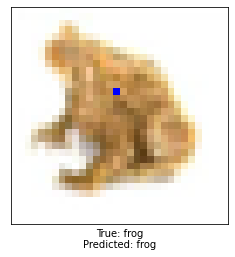

image frog classified as frog

 resnet - image 1448 - 5 / 50
Image successfully misclassified to class: dog with confidence 0.6168217062950134 (targeted: False)


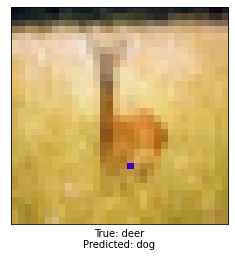

image deer classified as dog

 resnet - image 4463 - 6 / 50
Image successfully misclassified to class: bird with confidence 0.9973546266555786 (targeted: False)


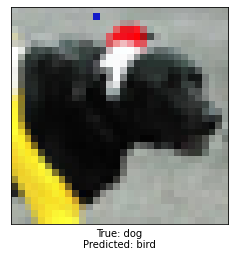

image dog classified as bird

 resnet - image 998 - 7 / 50


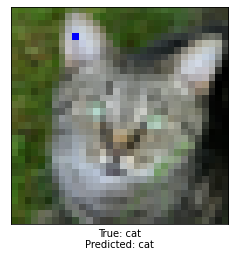

image cat classified as cat

 resnet - image 9025 - 8 / 50


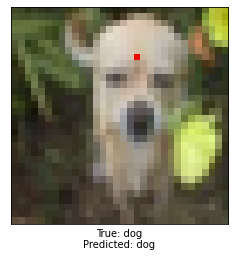

image dog classified as dog

 resnet - image 7915 - 9 / 50


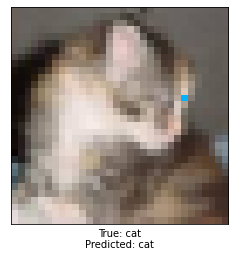

image cat classified as cat

 resnet - image 3747 - 10 / 50


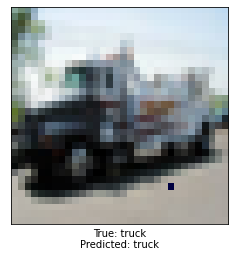

image truck classified as truck

 resnet - image 6381 - 11 / 50
Image successfully misclassified to class: automobile with confidence 0.8949721455574036 (targeted: False)


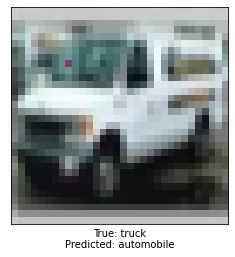

image truck classified as automobile

 resnet - image 3548 - 12 / 50


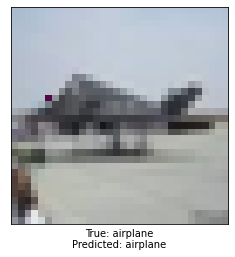

image airplane classified as airplane

 resnet - image 1369 - 13 / 50


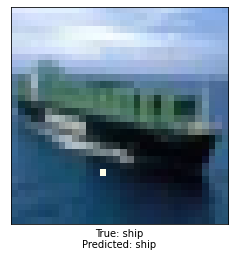

image ship classified as ship

 resnet - image 1540 - 14 / 50


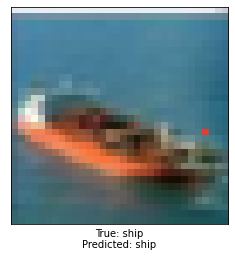

image ship classified as ship

 resnet - image 2634 - 15 / 50
Image successfully misclassified to class: frog with confidence 0.4022931158542633 (targeted: False)


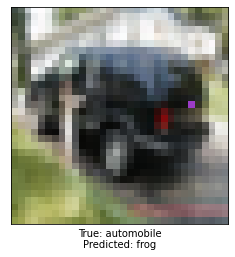

image automobile classified as frog

 resnet - image 5681 - 16 / 50


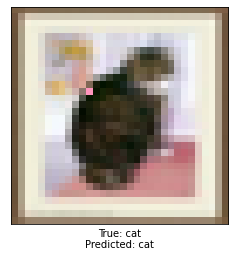

image cat classified as cat

 resnet - image 1400 - 17 / 50


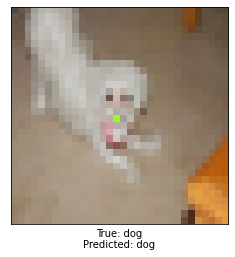

image dog classified as dog

 resnet - image 9550 - 18 / 50


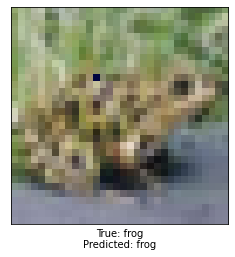

image frog classified as frog

 resnet - image 1802 - 19 / 50


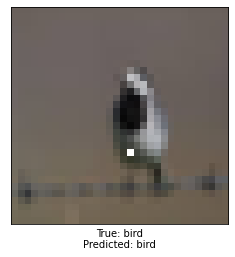

image bird classified as bird

 resnet - image 3886 - 20 / 50


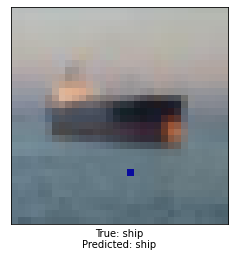

image ship classified as ship

 resnet - image 2498 - 21 / 50


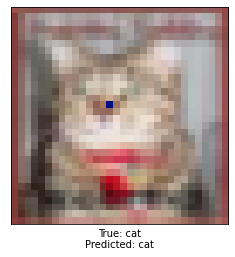

image cat classified as cat

 resnet - image 2426 - 22 / 50
Image successfully misclassified to class: airplane with confidence 0.9715424180030823 (targeted: False)


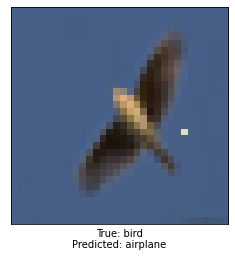

image bird classified as airplane

 resnet - image 9800 - 23 / 50


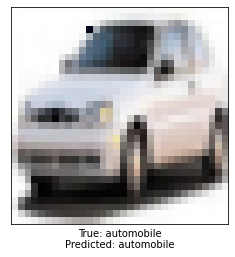

image automobile classified as automobile

 resnet - image 1517 - 24 / 50


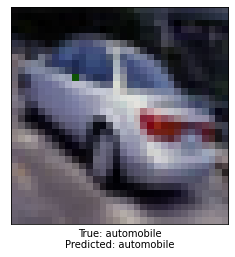

image automobile classified as automobile

 resnet - image 8703 - 25 / 50


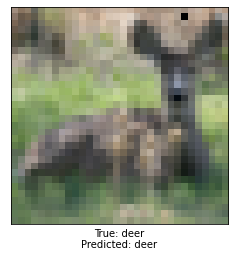

image deer classified as deer

 resnet - image 6211 - 26 / 50


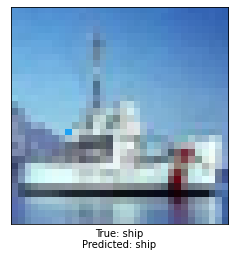

image ship classified as ship

 resnet - image 1675 - 27 / 50
Image successfully misclassified to class: airplane with confidence 0.9632695913314819 (targeted: False)


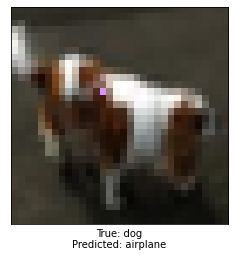

image dog classified as airplane

 resnet - image 5693 - 28 / 50


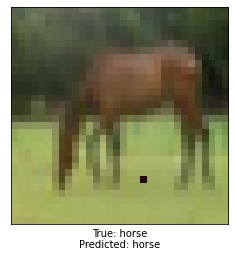

image horse classified as horse

 resnet - image 3175 - 29 / 50


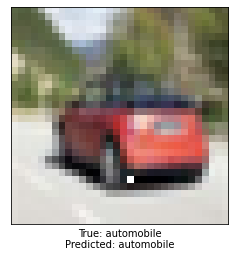

image automobile classified as automobile

 resnet - image 6806 - 30 / 50


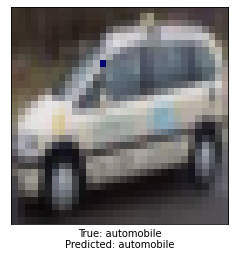

image automobile classified as automobile

 resnet - image 8678 - 31 / 50


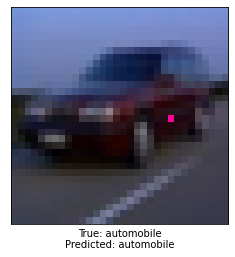

image automobile classified as automobile

 resnet - image 5497 - 32 / 50


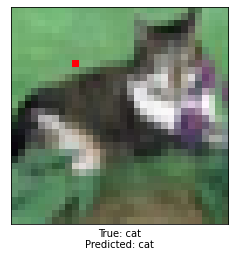

image cat classified as cat

 resnet - image 8766 - 33 / 50


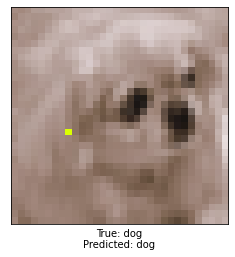

image dog classified as dog

 resnet - image 4175 - 34 / 50
Image successfully misclassified to class: bird with confidence 0.7160743474960327 (targeted: False)


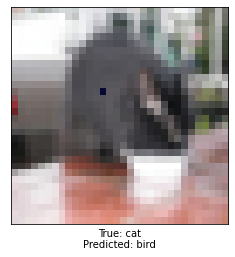

image cat classified as bird

 resnet - image 3282 - 35 / 50


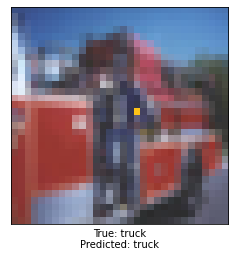

image truck classified as truck

 resnet - image 342 - 36 / 50
Image successfully misclassified to class: airplane with confidence 0.7525559663772583 (targeted: False)


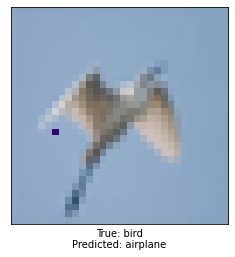

image bird classified as airplane

 resnet - image 3985 - 37 / 50
Image successfully misclassified to class: dog with confidence 0.5347267985343933 (targeted: False)


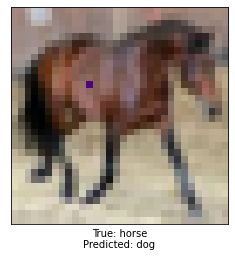

image horse classified as dog

 resnet - image 4921 - 38 / 50
Image successfully misclassified to class: frog with confidence 0.9253985285758972 (targeted: False)


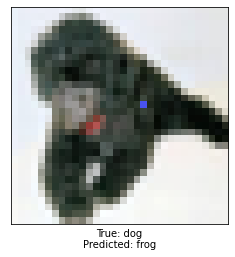

image dog classified as frog

 resnet - image 6026 - 39 / 50
Image successfully misclassified to class: dog with confidence 0.9959895014762878 (targeted: False)


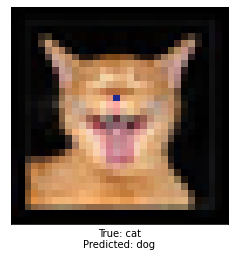

image cat classified as dog

 resnet - image 6804 - 40 / 50


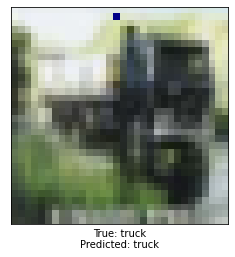

image truck classified as truck

 resnet - image 9642 - 41 / 50


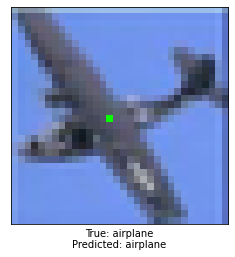

image airplane classified as airplane

 resnet - image 3868 - 42 / 50


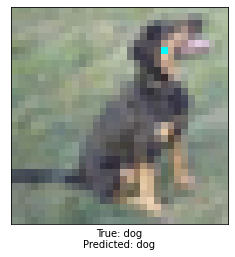

image dog classified as dog

 resnet - image 1264 - 43 / 50


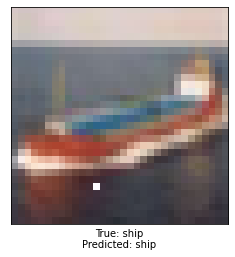

image ship classified as ship

 resnet - image 3077 - 44 / 50


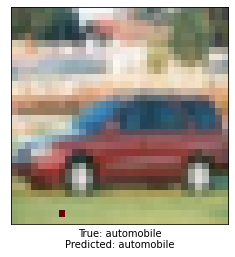

image automobile classified as automobile

 resnet - image 3218 - 45 / 50
Image successfully misclassified to class: ship with confidence 0.517750084400177 (targeted: False)


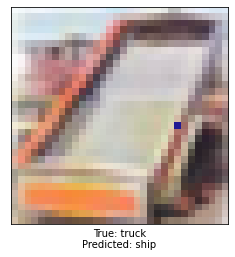

image truck classified as ship

 resnet - image 9605 - 46 / 50
Image successfully misclassified to class: cat with confidence 0.9985610842704773 (targeted: False)


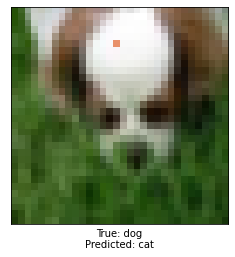

image dog classified as cat

 resnet - image 7350 - 47 / 50


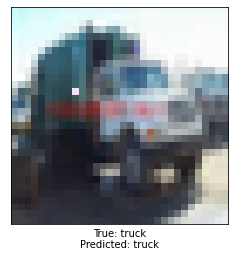

image truck classified as truck

 resnet - image 9135 - 48 / 50
Image successfully misclassified to class: dog with confidence 0.9773581027984619 (targeted: False)


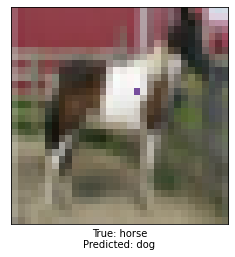

image horse classified as dog

 resnet - image 9138 - 49 / 50


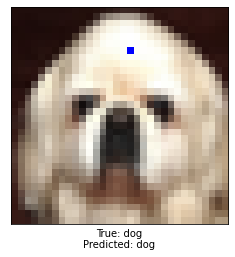

image dog classified as dog

 resnet - image 521 - 50 / 50


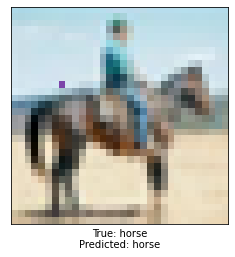

image horse classified as horse


In [ ]:
untargeted = attack_all(models, samples=50, targeted=False)


 pure_cnn - image 1633 - 1 / 10
Attacking with target airplane


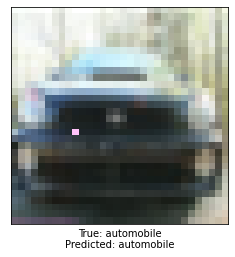

image automobile classified as automobile
Attacking with target automobile
Attacking with target bird


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:773: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


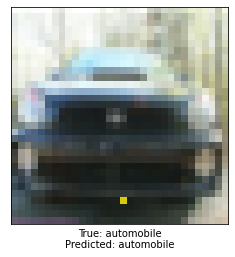

image automobile classified as automobile
Attacking with target cat


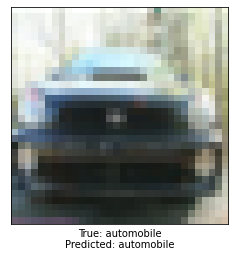

image automobile classified as automobile
Attacking with target deer


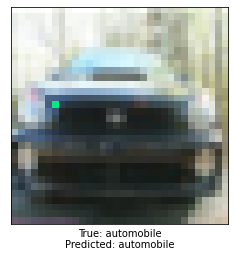

image automobile classified as automobile

 pure_cnn - image 9565 - 2 / 10
Attacking with target airplane
Attacking with target automobile


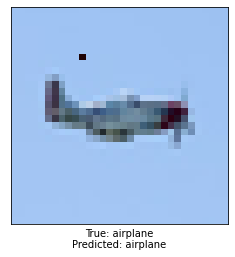

image airplane classified as airplane
Attacking with target bird


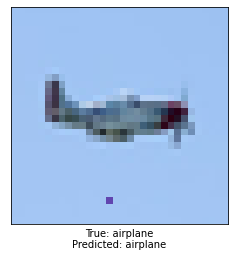

image airplane classified as airplane
Attacking with target cat


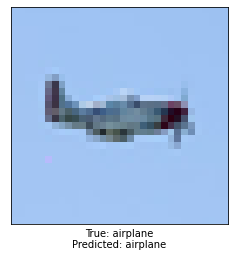

image airplane classified as airplane
Attacking with target deer


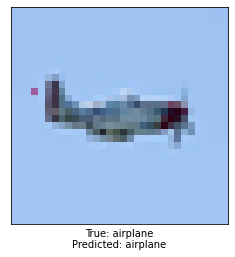

image airplane classified as airplane

 pure_cnn - image 2787 - 3 / 10
Attacking with target airplane


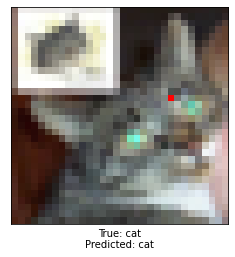

image cat classified as cat
Attacking with target automobile


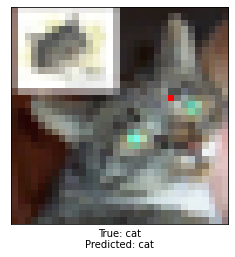

image cat classified as cat
Attacking with target bird


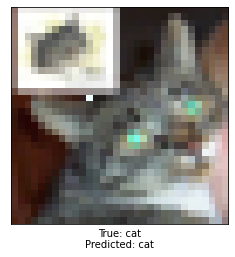

image cat classified as cat
Attacking with target cat
Attacking with target deer


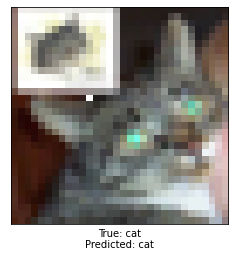

image cat classified as cat

 pure_cnn - image 5398 - 4 / 10
Attacking with target airplane
Image successfully misclassified to class: airplane with confidence 0.9296467304229736 (targeted: True)


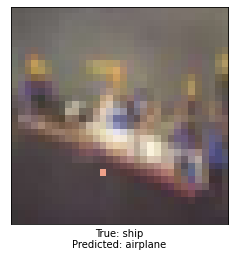

image ship classified as airplane
Attacking with target automobile


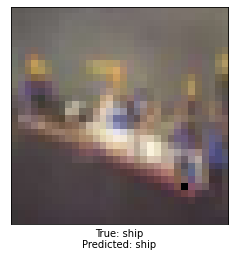

image ship classified as ship
Attacking with target bird


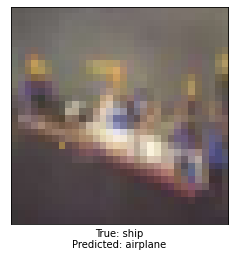

image ship classified as airplane
Attacking with target cat


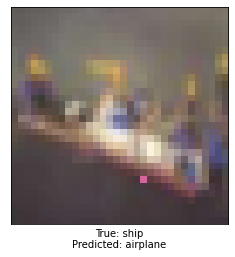

image ship classified as airplane
Attacking with target deer


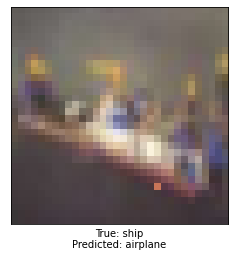

image ship classified as airplane

 pure_cnn - image 3857 - 5 / 10
Attacking with target airplane


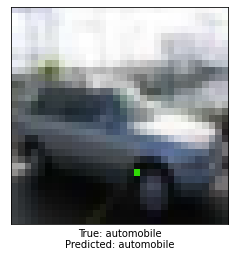

image automobile classified as automobile
Attacking with target automobile
Attacking with target bird


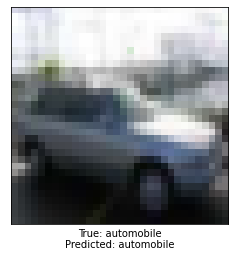

image automobile classified as automobile
Attacking with target cat


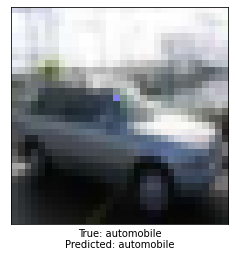

image automobile classified as automobile
Attacking with target deer


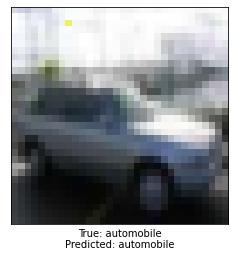

image automobile classified as automobile

 pure_cnn - image 5242 - 6 / 10
Attacking with target airplane
Attacking with target automobile


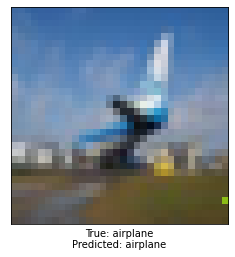

image airplane classified as airplane
Attacking with target bird


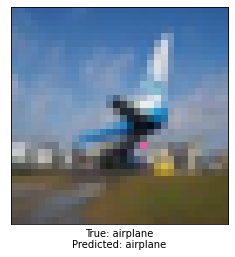

image airplane classified as airplane
Attacking with target cat


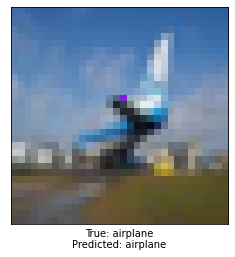

image airplane classified as airplane
Attacking with target deer


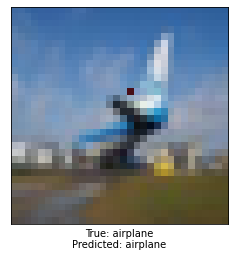

image airplane classified as airplane

 pure_cnn - image 7343 - 7 / 10
Attacking with target airplane


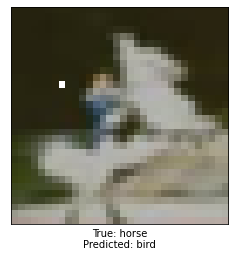

image horse classified as bird
Attacking with target automobile


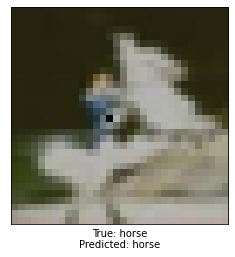

image horse classified as horse
Attacking with target bird
Image successfully misclassified to class: bird with confidence 0.8031176328659058 (targeted: True)


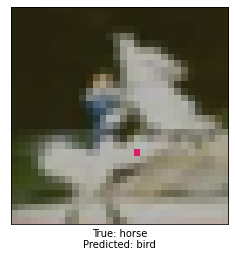

image horse classified as bird
Attacking with target cat


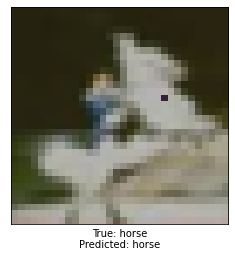

image horse classified as horse
Attacking with target deer


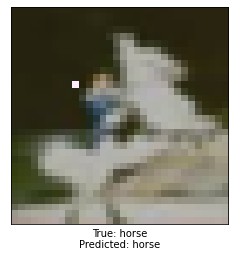

image horse classified as horse

 pure_cnn - image 6907 - 8 / 10
Attacking with target airplane


In [ ]:
targeted = attack_all(models, samples=10, targeted=True)

### Analyzing the data

Now that we have evaluated our attacks, it's time to look at their statistics.

In [ ]:
import pandas as pd
with open('networks/results/untargeted_results.pkl', 'rb') as file:
    untargeted = pickle.load(file)
with open('networks/results/targeted_results.pkl', 'rb') as file:
    targeted = pickle.load(file)

columns = ['model', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation', 'attack_image']
untargeted_results = pd.DataFrame(untargeted, columns=columns)
targeted_results = pd.DataFrame(targeted, columns=columns)

In [ ]:
df = untargeted_results
un_stats = []
for model in models:
    val_accuracy = np.array(network_stats[network_stats.name == model.name].accuracy)[0]
    m_result = df[df.model == model.name]

    p_result = m_result
    success_rate = len(p_result[p_result.success]) / len(p_result)
    un_stats.append([model.name, val_accuracy, success_rate])

In [ ]:
df = untargeted_results
tar_stats = []
for model in models:
    val_accuracy = np.array(network_stats[network_stats.name == model.name].accuracy)[0]
    m_result = df[df.model == model.name]

    p_result = m_result
    success_rate = len(p_result[p_result.success]) / len(p_result)
    tar_stats.append([model.name, val_accuracy, success_rate])

In [ ]:
pd.DataFrame(un_stats, columns=['model', 'accuracy', 'attack_success_rate'])

,model,accuracy,attack_success_rate
0,pure_cnn,0.887,0.262
1,resnet,0.923,0.326
2,densenet,0.946,0.369
3,wide_resnet,0.953,0.281


In [ ]:
pd.DataFrame(tar_stats, columns=['model', 'accuracy', 'attack_success_rate'])

,model,accuracy,attack_success_rate
0,pure_cnn,0.887,0.241
1,resnet,0.923,0.343
2,densenet,0.946,0.318
3,wide_resnet,0.953,0.256


### Going Even Further

In [ ]:
plt.imshow(x_test[20])
plt.imshow(succ[0] - x_test[20])

In [ ]:
np.where(succ[0] - x_test[20] != 0)

In [ ]:
succ[0][6][10]

In [ ]:
image_id = 20
pixel = np.array([4, 10, 236, 179, 8])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
confidence = predict_class(pixel, x_test[image_id], true_class, model)

print('New Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)

img_perturbed = perturb_single_image(pixel, x_test[image_id])

plt.axis('off')
plt.imshow(img_perturbed)

Prior confidence was 0.9958561
Confidence in true class frog is [0.6961524]
1


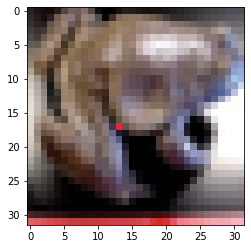

In [ ]:
image_id = 162
pixels = pixel_generator(150)
model = resnet
true_class = y_test[image_id, 0]
succ = bombard_image(pixels, image_id, class_names[true_class], model)
print(len(succ))

fig = plt.figure(figsize=(4, 4))
columns = 1
rows = len(succ)
for i in range(0, columns*rows):
    img = succ[i]
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)
plt.show()

(array([17, 17, 17]), array([13, 13, 13]), array([0, 1, 2]))

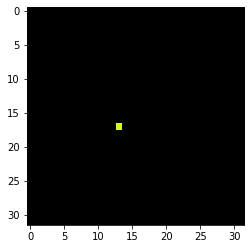

In [ ]:
plt.imshow(succ[0] - x_test[162])
np.where(succ[0] - x_test[162])

In [ ]:
r, g, b = succ[0][17][13]

(252, 26, 53)

In [ ]:
for image_id in range(500):
  img, label = x_test[image_id], y_test[image_id]
  conf = model.predict_one(img)[label]
  if 0.6 < conf < 0.7:
    print(image_id)

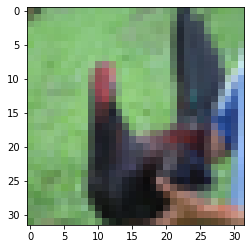

In [ ]:
plt.imshow(x_test[25])

In [ ]:
image_id = 25
true_label = class_names[y_test[image_id][0]]
model = resnet
for i in range(32):
  for j in range(32):
    pixel = np.array([i, j, 91, 61, 153])
    pert_img = perturb_single_image(pixel, x_test[image_id])
    preds = model.predict_one(pert_img)
    new_label = class_names[np.argmax(preds)]
    if new_label != true_label:
      print(i, j, new_label)

# true_class = y_test[image_id, 0]
# prior_confidence = model.predict_one(x_test[image_id])[true_class]
# confidence = predict_class(pixel, x_test[image_id], true_class, model)

# print('New Confidence in true class', class_names[true_class], 'is', confidence)
# print('Prior confidence was', prior_confidence)

# confidence = model.predict(succ[0])[0]
# predicted_class = np.argmax(confidence)
# print('Image successfully misclassified to class: {} with confidence {})'.format(class_names[predicted_class], confidence[predicted_class]))

# img_perturbed = perturb_single_image(pixel, x_test[image_id])

# plt.axis('off')
# plt.imshow(img_perturbed)